## Imports

In [5]:
# Data Management
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader.data import DataReader
from ta import add_all_ta_features


# Statistics
from statsmodels.tsa.stattools import adfuller

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Supervides Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

## Initial Data extraction

In [11]:
start_date = "2015-01-01"
end_date = "2024-12-31"
symbol = "BTC-USD"
df = yf.download(symbol, start=start_date, end=end_date)

df.index = pd.to_datetime(df.index)

# Flatten the MultiIndex columns
df.columns = df.columns.get_level_values(0) # Use the first level as the column name
print(df.head())

[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Date                                                                
2015-01-01  314.248993  320.434998  314.002991  320.434998   8036550
2015-01-02  315.032013  315.838989  313.565002  314.079010   7860650
2015-01-03  281.082001  315.149994  281.082001  314.846008  33054400
2015-01-04  264.195007  287.230011  257.612000  281.145996  55629100
2015-01-05  274.473999  278.341003  265.084015  265.084015  43962800


In [12]:
# Add TA
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

### Data Preprocessing - Stationary

In [13]:
# Identify non-stationary columns
non_stationaries = []
for col in df.columns:
    dftest = adfuller(df[col].values)
    p_values = dftest[1]
    t_test = dftest[0] < dftest[4]["1%"]
    if p_values > 0.05 or not t_test:
        non_stationaries.append(col)
print(f"Non-Stationary Features Found: {len(non_stationaries)}")

Non-Stationary Features Found: 34


In [14]:
# Convert non-stationaries to stationary
df_stationary = df.copy()
df_stationary[non_stationaries] = df_stationary[non_stationaries].pct_change()
df_stationary = df_stationary.iloc[1:]

In [15]:
# Find NaN Rows
na_list = df_stationary.columns[df_stationary.isna().any().tolist()]
df_stationary.drop(columns=na_list, inplace=True)

In [16]:
# Handle inf values
df_stationary.replace([np.inf, -np.inf], 0, inplace=True)
df_stationary.head()

Price,Close,High,Low,Open,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,...,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_stc,trend_adx,trend_adx_pos,trend_adx_neg,trend_cci,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,0.002492,-0.014343,-0.001395,-0.019835,-0.021888,-0.307416,0.978112,-0.323341,6.155046e+06,-72.813583,-72.813583,0.000000,-0.002216,0.000000,0.002492,0.001246,0.003738,-0.001246,0.497724,0.750000,0.0,0.0,-0.002240,-0.008639,0.004424,2.759248,0.443891,0.0,0.0,-0.001395,0.0,-0.000690,2.183443,0.213539,0.0,0.062463,0.012493,0.049971,0.001246,0.001246,...,0.009728,-0.000690,-0.000690,-0.000690,-0.000690,0.0,0.0,0.0,0.0,-66.666667,0.0,0.0,0.0,4.0,-4.0,0.0,0.000000,0.0,0.0,100.000000,0.0,0.0,0.0,100.000000,16.850581,21.353880,12.589268,-78.646120,0.000000,0.0,0.019873,0.003975,0.015899,-0.174885,-0.034977,-0.139908,0.001161,0.249172,0.248862,0.000000
2015-01-03,-0.107767,-0.002181,-0.103593,0.002442,3.205047,6.430539,-2.079259,-0.780253,-1.550381e+08,-1709.459814,-891.136699,-181.868336,-0.049414,0.000000,0.000000,-0.035552,0.062381,-0.133974,20.856989,0.146519,0.0,0.0,-0.024386,0.006912,-0.056558,9.263662,-0.437871,0.0,1.0,-0.103593,0.0,-0.051235,12.968342,0.000000,0.0,-2.597573,-0.509521,-2.088053,-0.035552,-0.035552,...,-0.364098,-0.051235,-0.051235,-0.051235,-0.051235,0.0,0.0,0.0,0.0,-100.000000,0.0,0.0,0.0,8.0,-8.0,0.0,0.000000,0.0,1.0,2.096744,0.0,0.0,0.0,34.975249,3.429679,0.000000,8.392846,-100.000000,0.000000,0.0,-0.832967,-0.163414,-0.669553,20.094762,3.990971,16.103791,-0.049280,-10.776686,-11.402782,-43.357783
2015-01-04,-0.060079,-0.088593,-0.083499,-0.107036,0.682956,0.809026,3.242318,-0.660687,-2.670910e+08,-1368.051200,-1050.108199,0.943412,-0.053661,0.000000,0.000000,-0.032344,0.006593,-0.080347,29.743883,0.162874,0.0,0.0,-0.030981,-0.017687,-0.045566,12.134520,-0.441941,0.0,1.0,-0.083499,0.0,-0.039018,21.394600,0.104787,0.0,-5.999156,-1.607448,-4.391709,-0.032344,-0.032344,...,-0.638869,-0.039018,-0.039018,-0.039018,-0.039018,0.0,0.0,0.0,0.0,-110.693896,0.0,0.0,0.0,12.0,-12.0,0.0,-0.002456,0.0,0.0,1.375421,0.0,0.0,0.0,-5.633494,11.120039,10.478659,10.610846,-89.521341,0.000000,0.0,-1.945780,-0.519887,-1.425893,40.169972,11.226771,28.943201,-0.058179,-6.007853,-6.195895,0.509151
2015-01-05,0.038907,-0.030947,0.029005,-0.057130,-0.209716,-0.265074,-0.603998,-0.341851,-1.643790e+08,-21.364710,-792.922327,-0.248443,-0.011687,30.631506,0.038907,-0.013054,-0.016430,-0.008498,28.957992,0.317302,0.0,0.0,-0.017202,-0.019279,-0.014858,11.686385,-0.045371,0.0,1.0,0.000000,0.0,0.000000,21.677574,0.268405,0.0,-7.775871,-2.841132,-4.934739,-0.013054,-0.013054,...,-0.663478,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,-76.487356,0.0,0.0,0.0,12.0,-12.0,0.0,-0.007763,0.0,0.0,19.523695,0.0,0.0,0.0,-17.685493,21.180304,26.840488,12.439716,-73.159512,0.000000,0.0,-2.542718,-0.924453,-1.618265,44.773678,17.936153,26.837526,-0.012941,3.890684,3.816904,-0.205358
2015-01-06,0.042682,0.0330

### Data Preprocessing - Scaling and Target Setting

In [17]:
# Set Target (for Supervised ML later on)
df_stationary["TARGET"] = -1
df_stationary.loc[df_stationary["Close"].shift(-1) > df_stationary["Close"], "TARGET"] = 1
df_stationary.dropna(inplace=True)

In [18]:
# Split Target from Features
X = df_stationary.iloc[:, :-1]
y = df_stationary.iloc[:, -1]

In [19]:
# Feature Scaling
df_sc = df_stationary.copy()
X_fs = StandardScaler().fit_transform(X)

In [20]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_fs, y, test_size=0.7, random_state=42)

### Unsupervised ML - PCA Dimensionality Reduction

In [21]:
# PCA
n_components = 8
pca = PCA(n_components=n_components)
pca_result = pca.fit(X_train)
X_train_pca = pca_result.transform(X_train)
X_test_pca = pca_result.transform(X_test)

In [23]:
# Calculate the variance explained by Principle Components
print("Variance of each component: ", pca.explained_variance_ratio_)
print("\nTotal Variance Explained: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Variance of each component:  [0.37432072 0.09302405 0.06142258 0.05062282 0.04345155 0.03332953
 0.02787226 0.02448718]

Total Variance Explained:  70.85


In [24]:
# Create columns
pca_cols = []
for i in range(n_components):
    pca_cols.append(f"PC_{i}")
pca_cols

['PC_0', 'PC_1', 'PC_2', 'PC_3', 'PC_4', 'PC_5', 'PC_6', 'PC_7']

In [25]:
# Create and View DataFrame
df_pca = pd.DataFrame(data=X_train_pca, columns=pca_cols)
df_pca.head()

,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7
0,2.936503,3.000677,-1.271857,-1.001338,-1.528866,1.769632,-1.054351,0.459382
1,7.543601,0.332430,1.258653,0.128989,0.508162,0.078556,-3.035658,1.155589
2,-10.847882,5.678620,1.029828,0.736825,1.493012,-2.213591,-1.021885,0.102620
3,2.603077,0.490215,-1.221308,0.623873,-1.939320,0.751639,-1.810053,0.171894
4,4.523512,-1.488311,2.588108,-1.327624,-0.455876,0.120781,0.565931,-0.535362


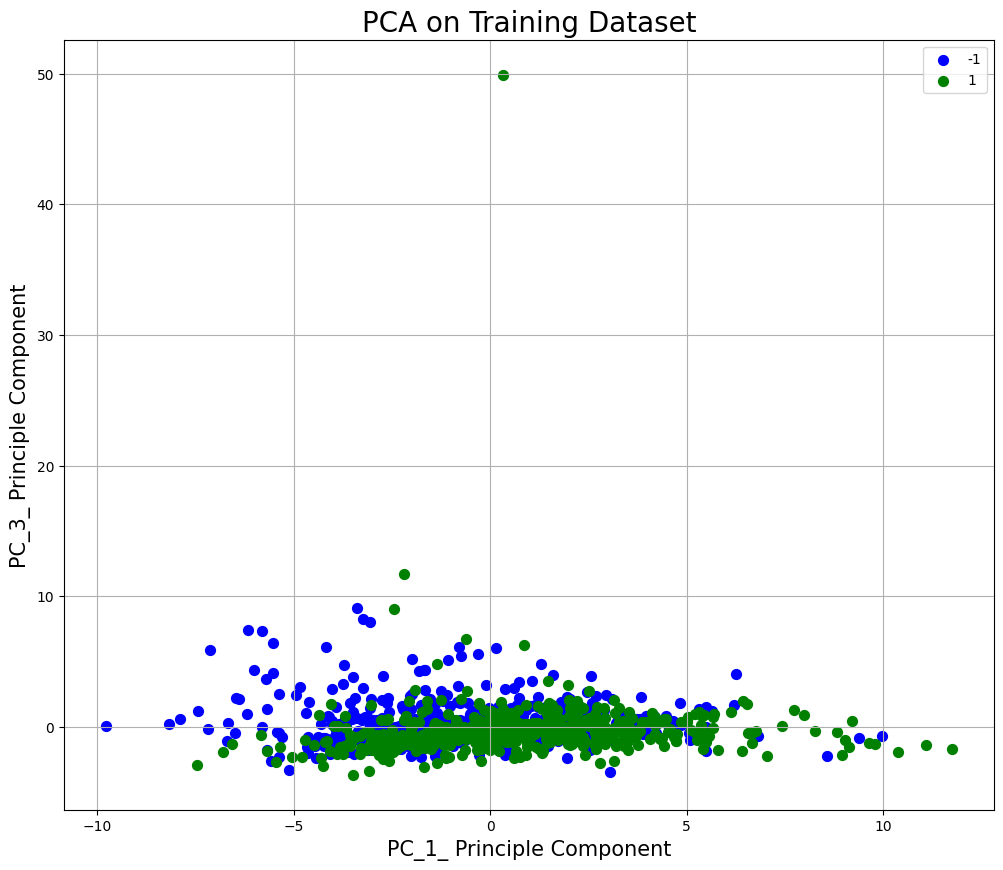

In [34]:
# Visualize Principle Components with Scatter Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1,1,1)
col_1 = "PC_1"
col_2 = "PC_3"
ax.set_xlabel(f"{col_1}_ Principle Component", fontsize=15)
ax.set_ylabel(f"{col_2}_ Principle Component", fontsize=15)
ax.set_title("PCA on Training Dataset", fontsize=20)

targets = [-1, 1]
colors = ['b', 'g']
for target, color in zip(targets, colors):
    indices_to_keep = y_train == target
    indices_to_keep = list(indices_to_keep)
    ax.scatter(df_pca.loc[indices_to_keep, col_1],
               df_pca.loc[indices_to_keep, col_2],
               c = color,
               s=50)
ax.legend(targets)
ax.grid()

### Supervised ML - Random Forest Clasification

In [29]:
classifier = RandomForestClassifier(n_estimators=12, max_depth=2, random_state=0)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")

Test Accuracy: 0.7437402190923318
Test Precision: 0.733852140077821


In [30]:
y_pred_proba = classifier.predict_proba(X_test)
y_pred_proba

array([[0.23868297, 0.76131703],
       [0.77614894, 0.22385106],
       [0.59599169, 0.40400831],
       ...,
       [0.34822719, 0.65177281],
       [0.4149747 , 0.5850253 ],
       [0.57770455, 0.42229545]])

In [31]:
# Test for Overfitting
train_scores, test_scores = list(), list()
values = [i for i in range(1, 200)]
for i in values:
    classifier = RandomForestClassifier(n_estimators=i, max_depth=2, random_state=0)
    classifier.fit(X_train, y_train)

    # Training Data
    y_train_pred = classifier.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_train_pred)
    train_scores.append(accuracy_train)

    # Test Data
    y_test_pred = classifier.predict(X_test)
    accuracy_test = accuracy_score(y_test, y_test_pred)
    test_scores.append(accuracy_test)

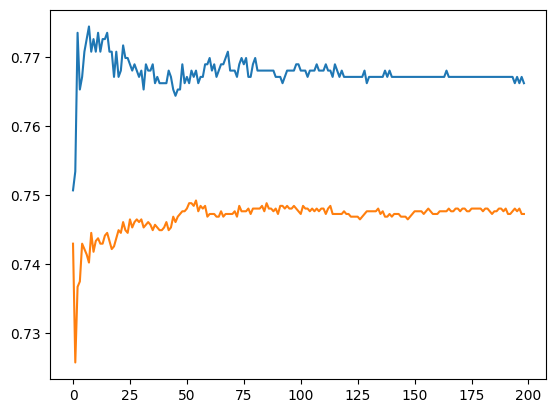

In [32]:
# Plot Results
plt.plot(train_scores)
plt.plot(test_scores)
plt.show()